<a href="https://colab.research.google.com/github/ashwinn-v/ConceteCrackClassifier/blob/main/ConcreteCrackfromScratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pwd


'/content'

using !wget to download the zip file

In [ ]:
!wget https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/5y9wdsg2zt-2.zip

--2020-12-05 14:04:35--  https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/5y9wdsg2zt-2.zip
Resolving md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)... 52.218.41.72
Connecting to md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)|52.218.41.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 240847944 (230M) [application/octet-stream]
Saving to: ‘5y9wdsg2zt-2.zip’

5y9wdsg2zt-2.zip    100%[===================>] 229.69M  22.4MB/s    in 11s     

2020-12-05 14:04:47 (20.2 MB/s) - ‘5y9wdsg2zt-2.zip’ saved [240847944/240847944]



Unzipping the zip file

In [ ]:
!unzip 5y9wdsg2zt-2.zip

Archive:  5y9wdsg2zt-2.zip
  inflating: Concrete Crack Images for Classification.rar  


In [ ]:
!ls

 5y9wdsg2zt-2.zip  'Concrete Crack Images for Classification.rar'   sample_data


Unarchiving the .rar file

In [ ]:
!unrar x 'Concrete Crack Images for Classification.rar'

Streaming output truncated to the last 5000 lines.
Extracting  Negative/15002.jpg                                            88%  OK 
Extracting  Negative/15003.jpg                                            88%  OK 
Extracting  Negative/15004.jpg                                            88%  OK 
Extracting  Negative/15005.jpg                                            88%  OK 
Extracting  Negative/15006.jpg                                            88%  OK 
Extracting  Negative/15007.jpg                                            88%  OK 
Extracting  Negative/15008.jpg                                            88%  OK 
Extracting  Negative/15009.jpg                                            88%  OK 
Extracting  Negative/15010.jpg                                            88%  OK 
Extracting  Negative/15011.jpg                                            88%  OK 
Extracting  Negative/15012.jp

In [ ]:
!ls

 5y9wdsg2zt-2.zip				 Negative   sample_data
'Concrete Crack Images for Classification.rar'	 Positive


In [ ]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
pip install split-folders tqdm

In [ ]:
import os
os.mkdir("/content/Images")

Splitting the true and false cases to two different folders

In [ ]:
import shutil
original = r'/content/Positive'
target = r'/content/Images/Positive'

shutil.move(original,target)

'/content/Images/Positive'

In [ ]:

original = r'/content/Negative'
target = r'/content/Images/Negative'

shutil.move(original,target)

'/content/Images/Negative'

In [ ]:
import splitfolders  # or import split_folders

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio("Images", output="Data1", seed=1337, ratio=(.8, .1, .1), group_prefix=None) # default values


Copying files: 40000 files [00:05, 7223.96 files/s]


In [ ]:
 ls

 5y9wdsg2zt-2.zip                                Data1/    sample_data/
'Concrete Crack Images for Classification.rar'   Images/


In [ ]:
base_dir = '/content/Data1'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')


In [ ]:
train_pos_dir = os.path.join(train_dir, 'Positive')
train_neg_dir = os.path.join(train_dir, 'Negative')
val_pos_dir = os.path.join(validation_dir, 'Positive')
val_neg_dir = os.path.join(validation_dir, 'Negative')

##**CNN Model Without Image Augmentation**

In [ ]:
from tensorflow import keras
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]


model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=METRICS)


train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')


validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

history = model.fit(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=50,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=1)

Found 32000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Epoch 1/50
100/100 [==============================] - 6s 57ms/step - loss: 0.3777 - tp: 893.0000 - fp: 208.0000 - tn: 790.0000 - fn: 109.0000 - accuracy: 0.8415 - precision: 0.8111 - recall: 0.8912 - auc: 0.9270 - val_loss: 0.0987 - val_tp: 499.0000 - val_fp: 4.0000 - val_tn: 472.0000 - val_fn: 25.0000 - val_accuracy: 0.9710 - val_precision: 0.9920 - val_recall: 0.9523 - val_auc: 0.9966
Epoch 2/50
100/100 [==============================] - 5s 50ms/step - loss: 0.1155 - tp: 949.0000 - fp: 21.0000 - tn: 973.0000 - fn: 57.0000 - accuracy: 0.9610 - precision: 0.9784 - recall: 0.9433 - auc: 0.9901 - val_loss: 0.0743 - val_tp: 492.0000 - val_fp: 8.0000 - val_tn: 493.0000 - val_fn: 7.0000 - val_accuracy: 0.9850 - val_precision: 0.9840 - val_recall: 0.9860 - val_auc: 0.9956
Epoch 3/50
100/100 [==============================] - 5s 50ms/step - loss: 0.0930 - tp: 938.0000 - fp: 15.0000 - tn: 1011.0000 - fn: 36.00

Plotting the graphs for Accuracy and Loss

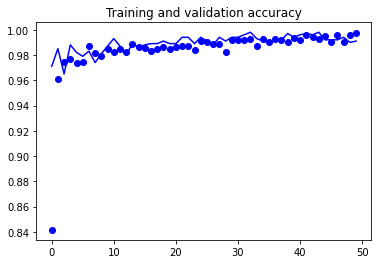

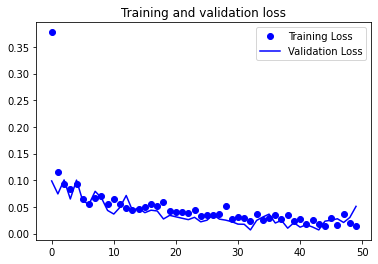

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## **CNN Model with Image Augmentation**

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
         
]


model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=METRICS)

# This code has changed. Now instead of the ImageGenerator just rescaling
# the image, we also rotate and do other operations
# Updated to do image augmentation
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

history = model.fit(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=5,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2)

Found 32000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Epoch 1/5
100/100 - 14s - loss: 0.3982 - tp: 920.0000 - fp: 285.0000 - tn: 706.0000 - fn: 89.0000 - accuracy: 0.8130 - precision: 0.7635 - recall: 0.9118 - auc: 0.9135 - val_loss: 0.1039 - val_tp: 478.0000 - val_fp: 7.0000 - val_tn: 501.0000 - val_fn: 14.0000 - val_accuracy: 0.9790 - val_precision: 0.9856 - val_recall: 0.9715 - val_auc: 0.9956
Epoch 2/5
100/100 - 14s - loss: 0.1320 - tp: 928.0000 - fp: 19.0000 - tn: 986.0000 - fn: 67.0000 - accuracy: 0.9570 - precision: 0.9799 - recall: 0.9327 - auc: 0.9882 - val_loss: 0.0676 - val_tp: 454.0000 - val_fp: 6.0000 - val_tn: 532.0000 - val_fn: 8.0000 - val_accuracy: 0.9860 - val_precision: 0.9870 - val_recall: 0.9827 - val_auc: 0.9962
Epoch 3/5
100/100 - 14s - loss: 0.0771 - tp: 957.0000 - fp: 16.0000 - tn: 993.0000 - fn: 34.0000 - accuracy: 0.9750 - precision: 0.9836 - recall: 0.9657 - auc: 0.9951 - val_loss: 0.0988 - val_tp: 493.0000 - val_fp: 25.0000 - 

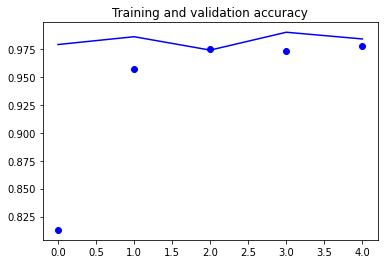

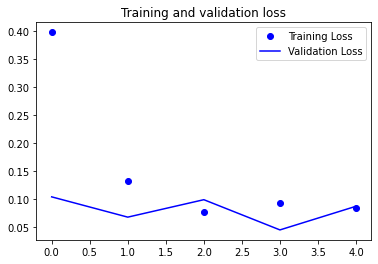

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()